# What secretion rate should we use in Jonklaas patients?

In [5]:
using Revise
using DifferentialEquations
using Thyrosim
using DiffEqCallbacks
using DiffEqParamEstim
using Plots
using Optim
using Statistics
using LinearAlgebra
using CSV

In [2]:
BLAS.set_num_threads(1)
Threads.nthreads()

8

# Import Jonklaas data

$$ \textbf{1st visit} \rightarrow \text{1 week} \rightarrow \textbf{2nd visit} \rightarrow \text{1 day} \rightarrow \textbf{SURGERY} \rightarrow \text{8 weeks} \rightarrow \textbf{3rd visit} \rightarrow \text{8 weeks} \rightarrow \textbf{4th visit}$$

+ 4 measurements of FT4, T3 and TSH for 50 patients. 
+ patients were never diagnosed with hyper/hypo-thyroidism
+ their first 2 TSH measurements were normal

In [43]:
# jonklaas data
patient_param, patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data_new()

([61.8 62.8 1.72 1.0; 64.1 67.1 1.6 0.0; … ; 57.7 58.5 1.68 0.0; 85.5 86.2 1.83 1.0], [100.0 112.0; 112.0 125.0; … ; 100.0 112.0; 175.0 175.0], [1.19 1.24 1.45 1.31; 1.14 0.98 1.64 1.61; … ; 1.4 1.14 1.44 1.8; 1.14 1.26 1.62 1.54], [1.71 1.71 1.44 1.14; 1.08 1.19 1.48 1.39; … ; 1.52 1.32 0.69 1.56; 1.22 0.96 1.39 1.45], [0.63 0.7 0.37 0.9; 1.4 1.6 0.82 0.45; … ; 1.4 0.9 3.7 1.2; 0.63 0.84 0.02 0.01])

In [80]:
function plot_sim_data(sol, T4end, T3end, TSHend)
    title = "Thyrosim simulation"
    
    # parameters to adjust figure limits
    p = sol.prob.p 
    t4lim, t3lim, tshlim = 140, 4, 10
    T4 = 777.0 * sol[1, :] / p[47]
    T3 = 651.0 * sol[4, :] / p[47]
    TSH = 5.6 * sol[7, :] / p[48]
    
    # set margins
    t4lim = max(1.2maximum(T4), 110.0)
    t3lim = max(1.2maximum(T3), 2.5)
    tshlim = max(1.2maximum(TSH), 5.5)
    
    # make T4/T3/TSH plots
    p1 = plot(sol.t / 24.0, T4, ylim=(0, t4lim), label="",
    ylabel="T4 (mcg/L)", title=title)
    p1 = hline!([45, 120], label= "")
    
    p2 = plot(sol.t / 24.0, T3, ylim=(0, t3lim), legend=false, 
       ylabel="T3 (mcg/L)")
    p2 = hline!([0.6, 1.8], legend=false)
    
    p3 = plot(sol.t / 24.0, TSH, ylim=(0, tshlim), legend=false,
       ylabel="TSH (mU/L)", xlabel="time [days]")
    p3 = hline!([0.45, 4.5], legend=false)
    
    # add ending points to subplots
    t_end = sol.t[end] / 24
#     scatter!(p1, [t_end], [T4end]],color="blue")
    scatter!(p2, [t_end], [T3end],  color="blue")
    scatter!(p3, [t_end], [TSHend], color="blue")
    
    plot(p1, p2, p3, layout=(3, 1))
end

plot_sim_data (generic function with 1 method)

# Simulate 1 patient using current best model

In [78]:
# import current best model
fitting_index = 
    [1; 21; 22; 
    30; 31; 
    49; 50; 51; 52; 53; 54;  # hill function parameters
    61; 62; 63;              # variance parameters
    66]
initial_guess = [ # start with good blakesley fit
    0.00238826; 0.0689; 127; 
    83.0787; 52.808; 
    5.62485; 4.4451; 7.355; 7.58711; 5.94623; 9.56078;
    5.0155; 1.0; 1.0;
    2.5]

# fit slow compartment, female Vp, using updated schneider's data
train_minimizer = [0.0021332692997945994, 0.045622884905307436, 155.11112968323192, 
    87.7444053267813, 54.173574203256976, 5.912616709611393, 4.437596759687524, 
    8.987476052706844, 7.982821283417989, 6.189266155053235, 12.247226806272158, 
    5.564095250270583, 0.0749120892018229, 0.32025141828813714, 3.6599430657147938];

# jobklaas patient parameters
weight_w1 = patient_param[:, 1]
height = patient_param[:, 3]
sex = Bool.(patient_param[:, 4])

# week 2 data
T4start = patient_t4[:, 2]
T3start = patient_t3[:, 2]
TSHstart = patient_tsh[:, 2];

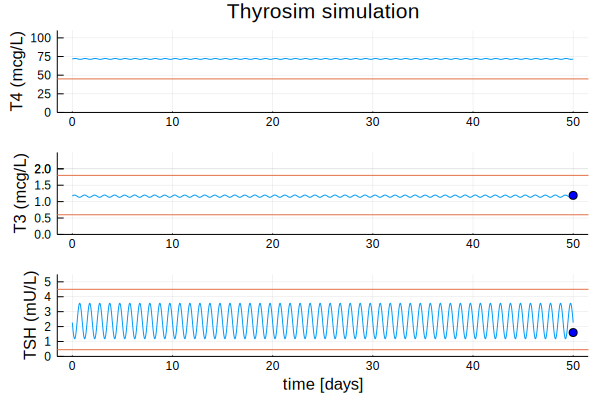

In [90]:
i = 2
dial = [1.0; 0.88; 1.0; 0.88] # T4 secretion, T4 absorbtion, T3 secret, T3 absorb
sol = simulate(height[i], weight_w1[i], sex[i], days=50, dial=dial, 
    fitting_index=fitting_index, parameters=train_minimizer)
plot_sim_data(sol, T4start[i], T3start[i], TSHstart[i])

# Predicted vs Actual initial condition

In [84]:
dial = [1.0; 0.88; 1.0; 0.88]
predictedT4 = Float64[]
predictedT3 = Float64[]
predictedTSH = Float64[]
for i in 1:size(patient_param, 1)
    sol = simulate(height[i], weight_w1[i], sex[i], days=50, dial=dial, 
        fitting_index=fitting_index, parameters=train_minimizer)
    
    # prediction
    _, p = initialize(dial, true, height[i], weight_w1[i], sex[i])
    push!(predictedT4, 777.0 * sol[end][1] / p[47])
    push!(predictedT3, 651.0 * sol[end][4] / p[47])
    push!(predictedTSH, 5.6 * sol[end][7] / p[48])
end

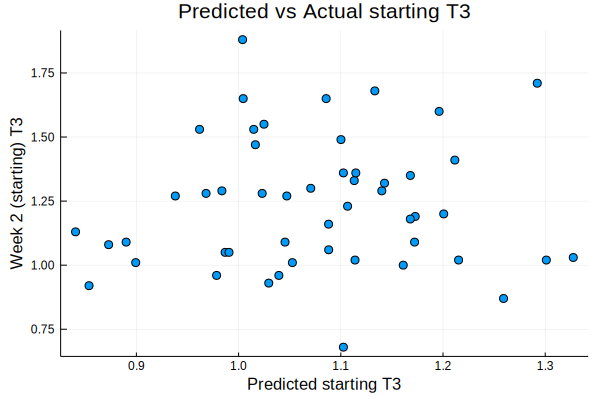

In [85]:
scatter(predictedT3, T3start, legend=false, title="Predicted vs Actual starting T3",
    xlabel="Predicted starting T3", ylabel="Week 2 (starting) T3")

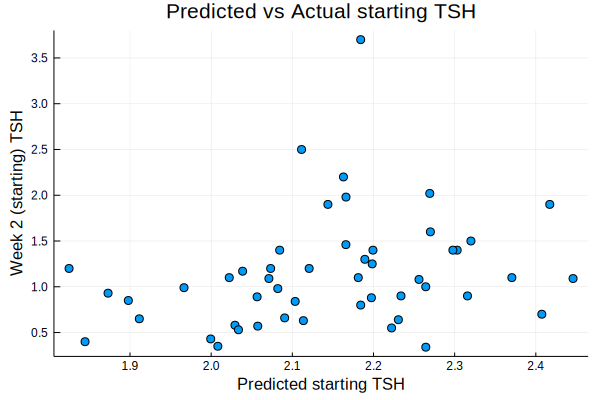

In [86]:
scatter(predictedTSH, TSHstart, legend=false, title="Predicted vs Actual starting TSH",
    xlabel="Predicted starting TSH", ylabel="Week 2 (starting) TSH")

# Setting initial condition still gives steady state after 8 weeks

In [98]:
function simulate_perturbation(
    h::Float64, # units meters
    w::Float64, # units kg
    sex::Bool; # true = male, false = female
    days::Int=56, 
    dial=[1.0; 0.88; 1.0; 0.88], 
    T4dose::Float64=0.0, # mcgs
    T3dose::Float64=0.0, # mcgs
    dosing_interval::Float64=24.0, #hours
    fitting_index = Int[],
    parameters = Float64[],
    T4init::Float64 = 150rand(),
    T3init::Float64 = 3rand(),    
    TSHinit::Float64 = 10rand(),    
    )
    function add_dose!(integrator)
        integrator.u[10] += integrator.p[55]
        integrator.u[12] += integrator.p[56]
    end
    cbk = PeriodicCallback(add_dose!, 24.0) 

    # initialize thyrosim parameters
    ic, p = initialize([1.0; 0.88; 1.0; 0.88], true, h, w, sex)
    p[fitting_index] .= parameters

    # run simulation for 30 days to get approximate steady state conditions
    # this assumes healthy patient without dose
    find_patient_ic!(ic, p, 30) 

    # setup daily dosing and fitting parameters 
    p[55] = T4dose / 777.0 # daily dose
    p[56] = T3dose / 651.0 # daily dose
    p[57:60] .= dial #set dial
    
    # purturbation
    ic[1] = T4init * p[47] / 777.0
    ic[4] = T3init * p[47] / 651
    ic[7] = TSHinit * p[48] / 5.6
    
    # solve and return ode solution
    prob = ODEProblem(thyrosim,ic,(0.0, 24days),p,callback=cbk)
    return solve(prob)
end


simulate_perturbation (generic function with 1 method)

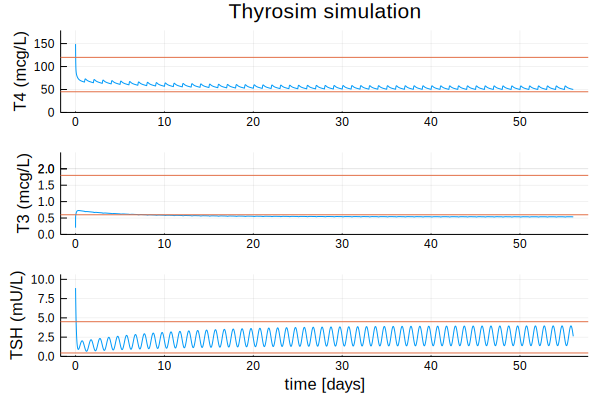

In [109]:
i = 35
dial = [0.0; 0.88; 0.0; 0.88] # T4 secretion, T4 absorbtion, T3 secret, T3 absorb
T4dose = 1.0 * weight_w1[i]
sol = simulate_perturbation(height[i], weight_w1[i], sex[i], dial=dial, T4dose=T4dose,
    fitting_index=fitting_index, parameters=train_minimizer)
output_plot(sol)